In [377]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm

from tensorflow.keras import Input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import (EarlyStopping,
                                        ReduceLROnPlateau,
                                        ModelCheckpoint)
from tensorflow.keras.layers import (Dense,
                                     Activation,
                                     Conv2D,
                                     MaxPooling2D,
                                     Flatten,
                                     Dropout,
                                     Lambda,
                                     ELU)

%matplotlib inline

TARGET_IMAGE_SIZE = (66, 220)
SEGMENT_N_FRAMES = 100
TRAIN_VAL_SPLIT = 0.8

DATA_DIR = 'data'
TRAIN_FILE = os.path.join(DATA_DIR, 'train.mp4')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TRAIN_TARGET_FILE = os.path.join(DATA_DIR, 'train.txt')

os.makedirs('models', exist_ok=True)
os.makedirs('assets', exist_ok=True)

DATETIME_FORMAT = '%Y-%m-%d %H:%M:%S'

In [378]:
# simple "progressbar" beause tqdm doesnt work well in jupyter
def progress(it, step=100):
    counter = 0
    for v in it:
        counter += 1
        if counter % step == 0:
            print(f'{datetime.now().strftime(DATETIME_FORMAT)}: '
                  f'processing item: {counter}')
        yield v

## Data Preparation

In [379]:
def read_frame(vidcap, frame_index):
    vidcap.set(1, frame_index)
    res, frame = vidcap.read()
    return cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)


def crop_and_resize(image):
    # w and h shifted
    return cv2.resize(image[30:350, :], TARGET_IMAGE_SIZE[::-1])


def change_brightness(image, factor, uint8_overflow=True):

    if uint8_overflow:
        return (image * factor).astype('uint8')
    else:
        return np.clip(image * factor, 0, 255).astype('uint8')

In [380]:
def preprocess_frame(frame):
    return change_brightness(
        crop_and_resize(frame),
        factor=(0.2 + np.random.rand()))


def prepare_image(frame_index, vidcap, target_dir, reset):
    image_path = os.path.join(target_dir, f'{frame_index}.jpg')

    if not os.path.exists(image_path) or reset:
        image = preprocess_frame(read_frame(vidcap, frame_index))
        cv2.imwrite(image_path, image)


def prepare_images(reset=False, source=TRAIN_FILE, target_dir=TRAIN_DIR):

    os.makedirs(target_dir, exist_ok=True)
    vidcap = cv2.VideoCapture(source)
    n_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

    for i in progress(range(n_frames), step=5000):
        prepare_image(i, vidcap, target_dir, reset)

    vidcap.release()

In [381]:
def train_val_split_ground_truth(random_state=0):

    ground_truth = pd.read_csv(TRAIN_TARGET_FILE, names=['speed'])
    ground_truth['frame_index'] = range(len(ground_truth))
    ground_truth['segment'] = [i // SEGMENT_N_FRAMES
                               for i in range(len(ground_truth))]

    n_segments = ground_truth['segment'].nunique()

    rng = np.random.RandomState(random_state)

    segment_val_split = {segment: rng.rand() > TRAIN_VAL_SPLIT
                         for segment in range(n_segments)}

    ground_truth['is_val'] = ground_truth['segment'].map(segment_val_split)
    return ground_truth


def create_image_pairs_with_speed(ground_truth):
    # add information about the next frame to each row
    for col in ('is_val', 'speed', 'frame_index'):
        ground_truth[f'{col}_next'] = ground_truth[col].shift(-1)

    # remove frames at the boundaries of train/val segments
    mask = ground_truth.apply(lambda r: r['is_val'] == r['is_val_next'], axis=1)
    ground_truth = ground_truth[mask].copy()
    assert not ground_truth.isna().any().any()

    ground_truth['frame_index_next'] = ground_truth['frame_index_next'].map(int)

    cols = ['frame_index', 'frame_index_next', 'segment',
            'speed', 'speed_next', 'is_val']

    return ground_truth[cols].to_dict('records')    

In [382]:
def plot_train_val_split(ground_truth):

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    val_mask = ground_truth['is_val']
    x = np.arange(0, len(ground_truth))

    ax.scatter(
        x[~val_mask],
        ground_truth.loc[~val_mask, 'speed'],
        c='blue',
        s=1,
        alpha=0.8,
        label='train')

    ax.scatter(
        x[val_mask],
        ground_truth.loc[val_mask, 'speed'],
        c='red',
        s=1,
        alpha=0.8,
        label='val')

    ax.set_xlabel('frame_index')
    ax.set_ylabel('speed [?]')
    ax.set_title('Frame Train/Validation Split')
    plt.legend()
    plt.show()

In [383]:
def read_image(frame_index):
    image_path = os.path.join(TRAIN_DIR, f'{frame_index}.jpg')
    return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


def read_image_pair(pair):
    return (read_image(pair['frame_index']),
            read_image(pair['frame_index_next']))


def get_pair_speed(pair):
    return np.mean([pair['speed'], pair['speed_next']])


def get_flow(image_0, image_1):
    # flow2hsv2rgb from
    # https://docs.opencv.org/master/d4/dee/tutorial_optical_flow.html
    # parameters from
    # https://github.com/JonathanCMitchell/speedChallenge/blob/master/NvidiaModel-OpticalFlowDense_kerasnew.ipynb

    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    if len(image_0.shape) == 2:
        hsv_shape = image_0.shape + (3,)
    else:
        hsv_shape = image_0.shape

    hsv = np.zeros(hsv_shape)
    # set saturation
    hsv[:, :, 1] = 255
    flow = cv2.calcOpticalFlowFarneback(image_0, image_1, flow_mat, image_scale,
                                        nb_images, win_size, nb_iterations, 
                                        deg_expansion, STD, 0)

    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # hue corresponds to direction
    hsv[:, :, 0] = ang * (180 / np.pi / 2)

    # value corresponds to magnitude
    hsv[:, :, 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

    hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    return rgb_flow.astype('float32') / 255

In [384]:
def get_train_val_image_pairs(image_pairs):

    val_pairs = filter(lambda x: x['is_val'], image_pairs)
    train_pairs = filter(lambda x: not x['is_val'], image_pairs)

    return list(train_pairs), list(val_pairs)


class ImageBatchGenerator(Sequence):

    def __init__(self, image_pairs, batch_size=32, shuffle=True):
        self._image_pairs = image_pairs
        self._batch_size = batch_size
        self._shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):

        return int(np.ceil(len(self._image_pairs) / self._batch_size))

    def __getitem__(self, index):

        start = index * self._batch_size
        end = (index + 1) * self._batch_size
        indexes_in_batch = self._indexes[start:end]

        selected_image_pairs = [self._image_pairs[i] for i in indexes_in_batch]
        return self._generate_batch(selected_image_pairs)

    def on_epoch_end(self):

        self._indexes = np.arange(len(self._image_pairs))
        if self._shuffle:
            np.random.shuffle(self._indexes)

    @staticmethod
    def _generate_batch(batch_image_pairs):
        y = np.array([get_pair_speed(pair) for pair in batch_image_pairs])
        X = np.array([get_flow(*read_image_pair(pair)) for pair in batch_image_pairs])

        return X, y

## Model

In [398]:
def neural_factory():
    # architecture from
    # https://arxiv.org/pdf/1604.07316v1.pdf

    input_shape = TARGET_IMAGE_SIZE + (3,)
    optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


    i = m = Input(shape=input_shape, name='input')
    m = Lambda(lambda x: x - 0.5, name='zero_center')(m)

    conv_architecture = (
        (24, (5, 5), (2, 2)),
        (36, (5, 5), (2, 2)),
        (48, (5, 5), (2, 2)),
        (64, (3, 3), (1, 1)),
        (64, (3, 3), (1, 1)))

    dense_architecture = (100, 50, 10)

    for k, (n_filters, kernel_size, strides) in enumerate(conv_architecture):

        m = Conv2D(n_filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='valid',
                   kernel_initializer='he_normal',
                   name=f'conv_{k}')(m)
        m = ELU(name=f'elu_conv_{k}')(m)
        if k == 2:
            m = Dropout(0.5, name='dropout')(m)

    m = Flatten(name='flatten')(m)

    for k, n_units in enumerate(dense_architecture):
        m = Dense(n_units,
                  kernel_initializer='he_normal',
                  name =f'dense_{k}')(m)
        m = ELU(name=f'dense_elu_{k}')(m)

    o = Dense(1, name='speed_estimation', kernel_initializer='he_normal')(m)

    model = Model(i, o)
    model.compile(optimizer=optimizer, loss='mse')

    return model


def get_callbacks():
    return [EarlyStopping(monitor='val_loss',
                          patience=10,
                          restore_best_weights=True)]

def plot_history(history):
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))

    ax.plot(history['loss'], 'r', label='train')
    ax.plot(history['val_loss'], 'b', label='val')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss value')
    ax.set_title('Loss - MSE')
    ax.legend()

    plt.tight_layout()
    plt.savefig('assets/history.svg')

## Model Training

In [79]:
prepare_images()

2020-07-22 07:23:38: processing item: 5000
2020-07-22 07:23:38: processing item: 10000
2020-07-22 07:23:38: processing item: 15000
2020-07-22 07:23:39: processing item: 20000


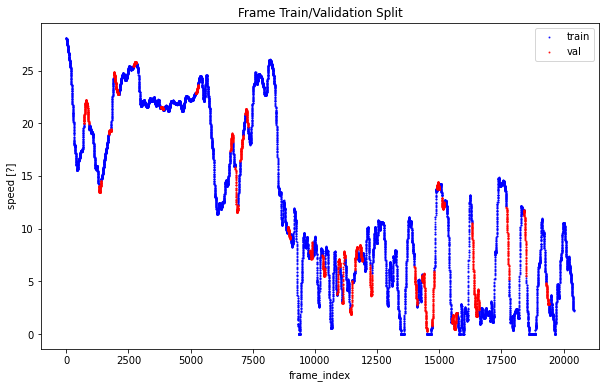

In [167]:
ground_truth = train_val_split_ground_truth()
image_pairs = create_image_pairs_with_speed(ground_truth)
plot_train_val_split(ground_truth)

In [29]:
model = neural_factory()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 66, 220, 3)]      0         
_________________________________________________________________
zero_center (Lambda)         (None, 66, 220, 3)        0         
_________________________________________________________________
conv_0 (Conv2D)              (None, 31, 108, 24)       1824      
_________________________________________________________________
elu_conv_0 (ELU)             (None, 31, 108, 24)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 14, 52, 36)        21636     
_________________________________________________________________
elu_conv_1 (ELU)             (None, 14, 52, 36)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 5, 24, 48)         4324

In [169]:
train_pairs, val_pairs = get_train_val_image_pairs(image_pairs)

In [94]:
model_name = '3'

model = load_model(f'models/model_{model_name}.h5')

# model.fit(
#     ImageBatchGenerator(train_pairs),
#     validation_data=ImageBatchGenerator(val_pairs),
#     epochs=15,
#     verbose=1,
#     callbacks=get_callbacks())
# model.save(f'models/model_{model_name}.h5')

# with open(f'models/history_{model_name}.json', 'w') as f:
#     json.dump(model.history.history, f)

val_loss: 11.98
loss: 7.73


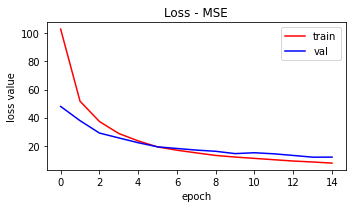

In [399]:
with open(f'models/history_{model_name}.json') as f:
    history = json.load(f)
    print(f"val_loss: {history['val_loss'][-1]:.2f}")
    print(f"loss: {history['loss'][-1]:.2f}")

    plot_history(history)

## Kalman Filtering

In [386]:
def kalman_filter(y_pred, Q, R, P):
    y_est = np.zeros(len(y_pred))
    y_est[0] = y_pred[0]

    P = np.array([P] + [0] * (len(y_pred) - 1))
    K = np.zeros(len(y_pred))

    for i in range(1, len(y_pred)):
        #project ahead
        y_est[i] = y_est[i - 1]
        P[i] = P[i - 1] + Q
        # step delay
        # update K, estimate, P
        K[i] = P[i] / (P[i] + R)
        y_est[i] = y_est[i] + K[i] * (y_pred[i] - y_est[i])
        P[i] = (1 - K[i]) * P[i]

    return y_est, P, K

In [387]:
def filter_segment(g):
    R = 0.5
    Q = 0.001
    P = 0.1

    speed_est, P, K = kalman_filter(g['speed_pred'].values, Q=Q, R=R, P=P)
    g['speed_est'] = speed_est
    g['kalman_P'] = P
    g['kalman_K'] = K
    return g

In [312]:
y_pred = model.predict(ImageBatchGenerator(val_pairs, shuffle=False))
y_pred_by_segment = pd.DataFrame(val_pairs)
y_pred_by_segment['speed_pred'] = y_pred
y_pred_by_segment = y_pred_by_segment.groupby('segment').apply(filter_segment)

## Final Results

In [388]:
def get_mse(df, col):
    return (df.apply(
        lambda r: r['speed'] - r[col], axis=1).values ** 2).mean()

print(f"Val MSE: {get_mse(y_pred_by_segment, 'speed_pred'):.2f}")
print(f"Val MSE (with Kalman filtering): {get_mse(y_pred_by_segment, 'speed_est'):.2f}")

Val MSE: 11.97
Val MSE (with Kalman filtering): 7.42


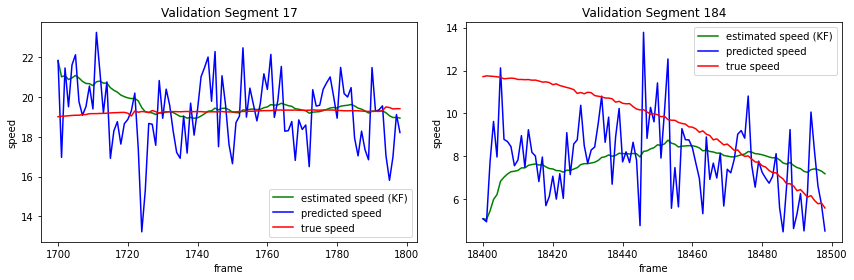

In [373]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for i, segment_index in enumerate((17, 184)):
    segment = y_pred_by_segment[y_pred_by_segment['segment'] == segment_index]

    ax[i].plot(segment['frame_index'], segment['speed_est'], c='g', label='estimated speed (KF)')
    ax[i].plot(segment['frame_index'], segment['speed_pred'], c='b', label='predicted speed')
    ax[i].plot(segment['frame_index'], segment['speed'], c='r', label='true speed')

    ax[i].set_xlabel('frame')
    ax[i].set_ylabel('speed')
    ax[i].set_title(f'Validation Segment {segment_index}')
    ax[i].legend()

plt.tight_layout()
plt.savefig('assets/kf.svg')
plt.show()

## Video Example

In [389]:
def create_segment(vidcap):
    segment_start, segment_end = 1700, 1850
    with open(TRAIN_TARGET_FILE) as f:
        y_true = [float(v) for v in f.read().split('\n')]

    segment = pd.DataFrame({
        'frame_index': range(segment_start, segment_end),
        'speed': y_true[segment_start:segment_end],
        'speed_pred': [predict_from_video(fi, vidcap, model)
                       for fi in range(segment_start, segment_end)]})

    return filter_segment(segment)


def predict_from_video(frame_index, vidcap, model):
    if frame_index < 1:
        raise ValueError('frame_index must be grater than 1.')

    image_pair = [preprocess_frame(read_frame(vidcap, fi))
                  for fi in (frame_index - 1, frame_index)]

    flow = get_flow(*image_pair)
    return model.predict(flow[np.newaxis, ...])[0][0]


def create_frame(vidcap, row):

    frame = read_frame(vidcap, row['frame_index'])

    font = cv2.FONT_HERSHEY_PLAIN
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    error = row['speed'] - row['speed_est']

    for text, y_offset in ((f"True speed: {row['speed']:.2f}", 120),
                           (f"Estimated speed: {row['speed_est']:.2f}", 90),
                           (f"KF estimate var: {row['kalman_P']:.5f}", 60),
                           (f"KF gain: {row['kalman_K']:.5f}", 30),
                           (f"Error: {error:.2f}", 0)):

        frame = cv2.putText(frame, text, (10, 450 - y_offset),
                            font, 1.5, (0, 255, 0), 1, cv2.LINE_AA)

    return frame


def create_video(segment, vidcap):

    frames = [create_frame(vidcap, row) for _, row in segment.iterrows()]

    fourcc =  cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter('assets/example.mp4', fourcc, 20.0, (640, 480))
    for frame in frames:
        out.write(frame)

    out.release()

In [363]:
vidcap = cv2.VideoCapture(TRAIN_FILE)
segment = create_segment(vidcap)
frames = create_video(segment, vidcap)
vidcap.release()